In [1]:
%pylab inline

from astropy.io import fits as pyf
import os
from itertools import product, combinations
from matplotlib.mlab import griddata
from tools.photometry import AB2flux as flux
from scipy.optimize import leastsq

from styles import slides

Populating the interactive namespace from numpy and matplotlib


In [2]:
def theta_ij(sed_i, sed_j):
    norm_i = np.sqrt(np.dot(sed_i, sed_i))
    norm_j = np.sqrt(np.dot(sed_j, sed_j))
    return np.arccos(np.dot(sed_i, sed_j) / (norm_i * norm_j)) * 180.0 / np.pi

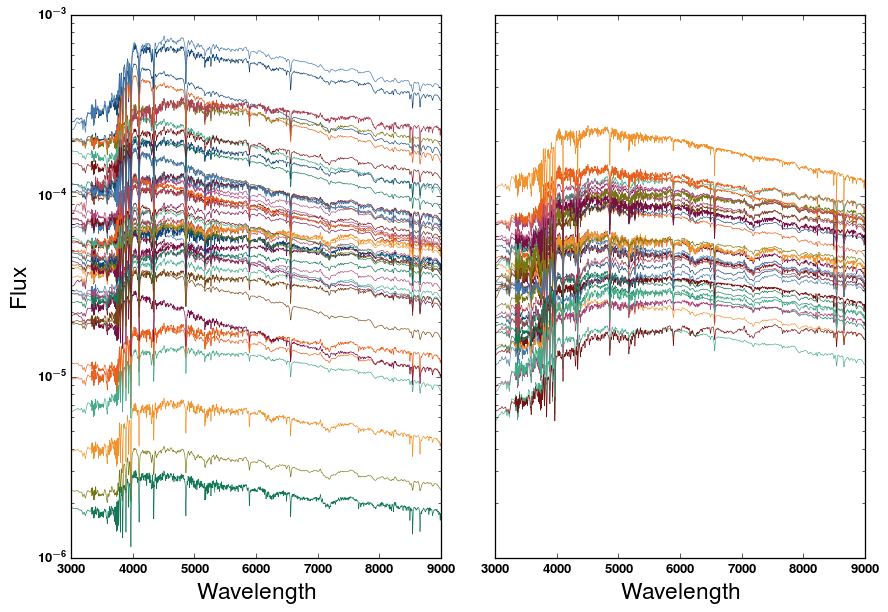

In [3]:
fig, axs = subplots(1, 2, figsize=(10, 7), sharex=True, sharey=True)

xlim(3000, 9000)
ylim(1e-6, 1e-3)

sfh_list = sorted([os.path.join(root, file) for root, subs, files in os.walk("../inputs/SSAG_set/") for file in files if file.endswith("fits.gz")])

fluxes, ages, mass1gyr, mass1myr, b4000 = [], [], [], [], []
ur, ur0, z0, t0 = [], [], [], []
for fits in sfh_list:
    f = pyf.open(fits)

    t = f[2].data["Age"]
    sfr = f[2].data["SFR"]
    mass1myr.append((0.5*(sfr[1:]+sfr[:-1])*(t[1:]-t[:-1]))[t[1:]>=t.max() - 1e6].sum()/f[0].header["MASS"])
    mass1gyr.append(f[0].header["MASS1GYR"]/f[0].header["MASS"])
    z0.append(f[0].header["Z"])
    t0.append(f[0].header["PRFWLA"])
    ur.append(f[0].header["UMAG"]-f[0].header["RMAG"])
    ur0.append(f[0].header["PUMAG"]-f[0].header["PRMAG"])
    
    if not f[0].header["UMAG"]-f[0].header["RMAG"] < 2.22: continue

    wlength = f[1].data["Wavelength"]
    flux = f[1].data["Flux"]
    
    fluxes.append(flux)
    ages.append(f[0].header["RFWLA"])
    b4000.append(f[0].header["B4VN"])
    
    if f[0].header["RFWLA"]< 9.0: axs[0].semilogy(wlength, flux, "-", lw=0.5)
    if f[0].header["RFWLA"]>=9.0: axs[1].semilogy(wlength, flux, "-", lw=0.5)

axs[0].set_xlabel("Wavelength")
axs[1].set_xlabel("Wavelength")
axs[0].set_ylabel("Flux")
tight_layout()
#savefig("img/SFGs.pdf", bbox_inches="tight")

fluxes = np.array(fluxes).T
ages = np.array(ages)
mass1myr = array(mass1myr)
mass1gyr = array(mass1gyr)
t0 = array(t0)
z0 = log10(array(z0))
ur = array(ur)
ur0 = array(ur0)
b4000 = array(b4000)

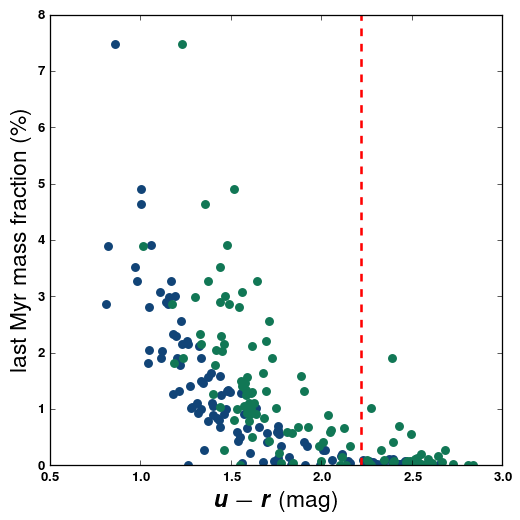

In [4]:
fig, ax = subplots(1, 1)

plot(ur0, mass1myr*100., "o")
plot(ur, mass1myr*100., "o")
axvline(2.22, ls="--", color="r")

xlabel(r"$u-r$ (mag)")
ylabel(r"last Myr mass fraction (\%)")

tight_layout()
#savefig("img/color_vs_sfr.pdf", bbox_inches="tight")

In [5]:
t0, z0, u, r = loadtxt("../inputs/tta_bc03/SSAG_catalog.txt", usecols=(52, 13, 40, 42), unpack=True) #(22, 12, 26, 28)
trun = loadtxt("../inputs/tta_bc03/SSAG_catalog.txt", dtype=np.str, usecols=(10,))

mask = ~array([eval(trun[i]) for i in xrange(trun.size)], dtype=np.bool)
t0, z0, ur0 = t0[mask], log10(z0[mask]), (u-r)[mask]

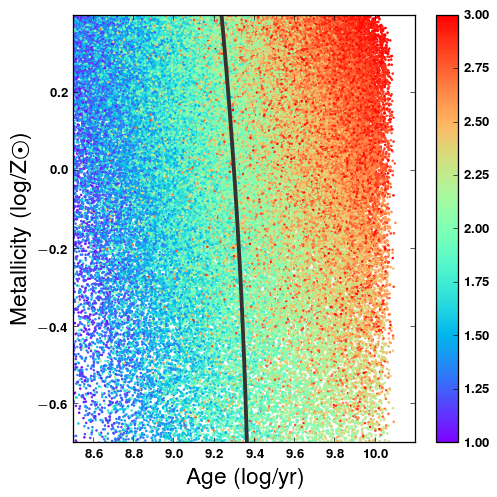

In [6]:
def model(pars, y):
    a, b, c = pars
    return a*asarray(y)**2 + b*asarray(y) + c

def residuals(pars, x, y):
    return y - model(pars, x)

fig, ax = subplots(1, 1)

xlim(8.5, 10.2)
ylim(-0.7, 0.4)
xlabel(r"Age (log/yr)")
ylabel(r"Metallicity (log/Z$\odot$)")


cmin, cmax = 1, 3
mask = (cmin<ur0)&(ur0<cmax)
print 
scatter(t0[mask], z0[mask], s=4, c=ur0[mask], lw=0, vmin=cmin, vmax=cmax, cmap=cm.rainbow)
colorbar()

pars = leastsq(residuals, [1, 1, 1], (z0[mask], t0[mask]))

y = linspace(-0.7, 0.4)
plot(model(pars[0], y), y, '-', lw=3, color="0.2")